# Cirrhosis classification

- Using Shotgun metagenomics for disease prediction
- sequence the genomes of untargeted cells in a community in order to elucidate community composition and function.

### Methods
- classification issue
- response : cirrhosis against healthy samples
- first of all I approach prediction cirrhosis using XGBoost 

- compare with RF here (https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004977) by using **the reduced dataset for ongoing experimentation.**



In [7]:
from xgboost import XGBClassifier
import xgboost as xgb
import os
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score

import seaborn as sns
#import scikitplot as skplt
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Metaparameters
VERBOSE = 0
FOLDS = 5

show_fold_stats = True
# show_fold_stats = False # set to True if all OOF results wanted

do_plot_ROC = False # set to True to plot ROC when predicting cirrhosis

# test_train_split_SEED = 1970
test_train_split_SEED = 1971

In [6]:
def plot_ROC(fpr, tpr, m_name):
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC for %s'%m_name, fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

In [11]:
pd_abundance = pd.read_csv('data/Metagenomic_segata_2016/abundance_stoolsubset.txt', dtype=str, sep='\t')
pd_abundance

,dataset_name,Candela_Africa,Candela_Africa.1,Candela_Africa.2,Candela_Africa.3,Candela_Africa.4,Candela_Africa.5,Candela_Africa.6,Candela_Africa.7,Candela_Africa.8,...,Zeller_fecal_colorectal_cancer.124,Zeller_fecal_colorectal_cancer.125,Zeller_fecal_colorectal_cancer.126,Zeller_fecal_colorectal_cancer.127,Zeller_fecal_colorectal_cancer.128,Zeller_fecal_colorectal_cancer.129,Zeller_fecal_colorectal_cancer.130,Zeller_fecal_colorectal_cancer.131,Zeller_fecal_colorectal_cancer.132,Zeller_fecal_colorectal_cancer.133
0,sampleID,H10,H11,H12,H13,H14,H15,H16,H17,H18,...,CCIS91228662ST-4-0,CCIS93040568ST-20-0,CCIS94417875ST-3-0,CCIS94496512ST-4-0,CCIS95097901ST-4-0,CCIS95409808ST-4-0,CCIS96387239ST-4-0,CCIS98482370ST-3-0,CCIS98512455ST-4-0,CCIS98832363ST-4-0
1,subjectID,h10,h11,h12,h13,h14,h15,h16,h17,h18,...,fr-275,fr-682,fr-110,fr-229,fr-696,fr-152,fr-626,fr-052,fr-459,fr-552
2,bodysite,stool,stool,stool,stool,stool,stool,stool,stool,stool,...,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool
3,disease,n,n,n,n,n,n,n,n,n,...,cancer,n,n,small_adenoma,n,n,small_adenoma,n,cancer,cancer
4,age,40,29,8,34,30,16,21,23,17,...,63,65,59,64,52,63,66,53,63,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2334,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2335,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2336,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
pd_abundance = pd.read_csv('data/Metagenomic_segata_2016/abundance_stoolsubset.csv', dtype=str)
disease = pd_abundance.loc[:,'disease'] 
d_name = pd_abundance.loc[:,'dataset_name'] 
print(disease.value_counts())
print('-'*100)
print(d_name.value_counts())

# list of diseases we want to analyze and predict
diseases = ['obesity', 'cirrhosis', 't2d', 'cancer']

disease
n                             944
t2d                           223
obesity                       164
ibd_ulcerative_colitis        148
cirrhosis                     118
leaness                        89
stec2-positive                 52
impaired_glucose_tolerance     49
cancer                         48
n_relative                     47
small_adenoma                  26
ibd_crohn_disease              25
 -                             20
large_adenoma                  13
overweight                     10
-                               7
obese                           5
underweight                     1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
dataset_name
Neilsen_genome_assembly              382
t2dmeta_long                         290
Chatelier_gut_obesity                278
Quin_gut_liver_cirrhosis             232
hmp                                  152
WT2D                               

In [ ]:
cols = pd_abundance.columns.tolist()

# separate data from metadata
species = [x for x in cols if x.startswith('k_')]
metadata = [x for x in cols if not x.startswith('k_')]

pd_abundance_conv = pd_abundance.copy()
pd_abundance_conv = pd_abundance_conv[species].astype('float64')
pd_abundance_conv = pd.concat([pd_abundance[metadata], pd_abundance_conv], axis = 1)

In [19]:
pd_abundance_conv.head()

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
0,Candela_Africa,H10,h10,stool,n,40,female,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Candela_Africa,H11,h11,stool,n,29,female,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Candela_Africa,H12,h12,stool,n,8,female,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Candela_Africa,H13,h13,stool,n,34,male,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Candela_Africa,H14,h14,stool,n,30,male,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# controls/healthy samples from Human Microbiome Project coded 'hmp' and 'hmpii'. 
# 't2d' stands for Type 2 Diabetes. We will combine a few studies into single dataset.
data_sets = {'control':['hmp', 'hmpii'],'t2d':['WT2D','t2dmeta_long','t2dmeta_short'], 'cirrhosis' : ['Quin_gut_liver_cirrhosis'], 
             'cancer' : ['Zeller_fecal_colorectal_cancer'], 'obesity' : ['Chatelier_gut_obesity']}
# combine controls from different studies into one
pd_abundance_conv['disease'] = pd_abundance_conv['disease'].apply(lambda x: 'control' if ((x == 'n') or (x == 'nd') or (x == 'leaness')) else x)

In [22]:
pd_abundance_conv['disease'].value_counts()

disease
control                       1033
t2d                            223
obesity                        164
ibd_ulcerative_colitis         148
cirrhosis                      118
stec2-positive                  52
impaired_glucose_tolerance      49
cancer                          48
n_relative                      47
small_adenoma                   26
ibd_crohn_disease               25
 -                              20
large_adenoma                   13
overweight                      10
-                                7
obese                            5
underweight                      1
Name: count, dtype: int64

In [25]:
# separate controls and diseases into 2 dataframes
pd_control = pd_abundance_conv.loc[pd_abundance_conv['disease'] == 'control']
pd_disease = pd_abundance_conv.loc[pd_abundance_conv['disease'] != 'control']

print(
    pd_control.shape,
    pd_disease.shape,
)

print(pd_disease.disease.unique())

(1033, 2339) (956, 2339)
['obesity' 'stec2-positive' ' -' 'ibd_ulcerative_colitis'
 'ibd_crohn_disease' 'n_relative' 'cirrhosis' 'obese' 'overweight' '-'
 'underweight' 't2d' 'impaired_glucose_tolerance' 'cancer' 'small_adenoma'
 'large_adenoma']


In [26]:
# we won't consider diseases from this list
not_disease = [d for d in pd_disease.disease.unique().tolist() if d not in diseases] 
for d in not_disease:
    pd_disease = pd_disease.drop(pd_disease.loc[pd_disease['disease'] == d].index, axis = 0)  

print(
    pd_control.shape,
    pd_disease.shape,
)  

(1033, 2339) (553, 2339)


In [37]:
ds_names = data_sets['cirrhosis']
pd_cont = pd_control.loc[pd_control['dataset_name'] == ds_names[0]]
pd_dis = pd_disease.loc[pd_disease['dataset_name'] == ds_names[0]]

print(
    pd_cont.shape,
    pd_dis.shape
)

(114, 2339) (118, 2339)


In [46]:
merge = pd.concat([
    pd_cont,
    pd_dis
],axis=0).set_index('sampleID')

merge.head()

,dataset_name,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
sampleID,,,,,,,,,,,,,,,,,,,,,
HD-10,Quin_gut_liver_cirrhosis,hd-10,stool,control,40,female,china,Illumina,25079328,nd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HD-11,Quin_gut_liver_cirrhosis,hd-11,stool,control,38,female,china,Illumina,25079328,nd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HD-12,Quin_gut_liver_cirrhosis,hd-12,stool,control,40,male,china,Illumina,25079328,nd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HD-13,Quin_gut_liver_cirrhosis,hd-13,stool,control,56,female,china,Illumina,25079328,nd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HD-14,Quin_gut_liver_cirrhosis,hd-14,stool,control,51,male,china,Illumina,25079328,nd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = merge.select_dtypes('float').values
y = merge['disease'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
len(X)

232

In [69]:
from sklearn.ensemble import RandomForestClassifier # for multiple algorithm (that why is called ensemble)
model = RandomForestClassifier(n_estimators=25)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=25)

In [70]:
model.score(X_test, y_test)

0.8936170212765957

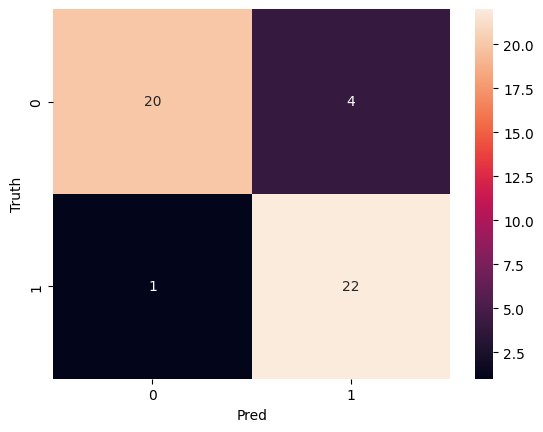

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model.predict(X_test))

sns.heatmap(cm, annot=True)
plt.xlabel('Pred')
plt.ylabel('Truth')
plt.savefig('issues/RF_cm_cirrhosis_ds.png', dpi=300)

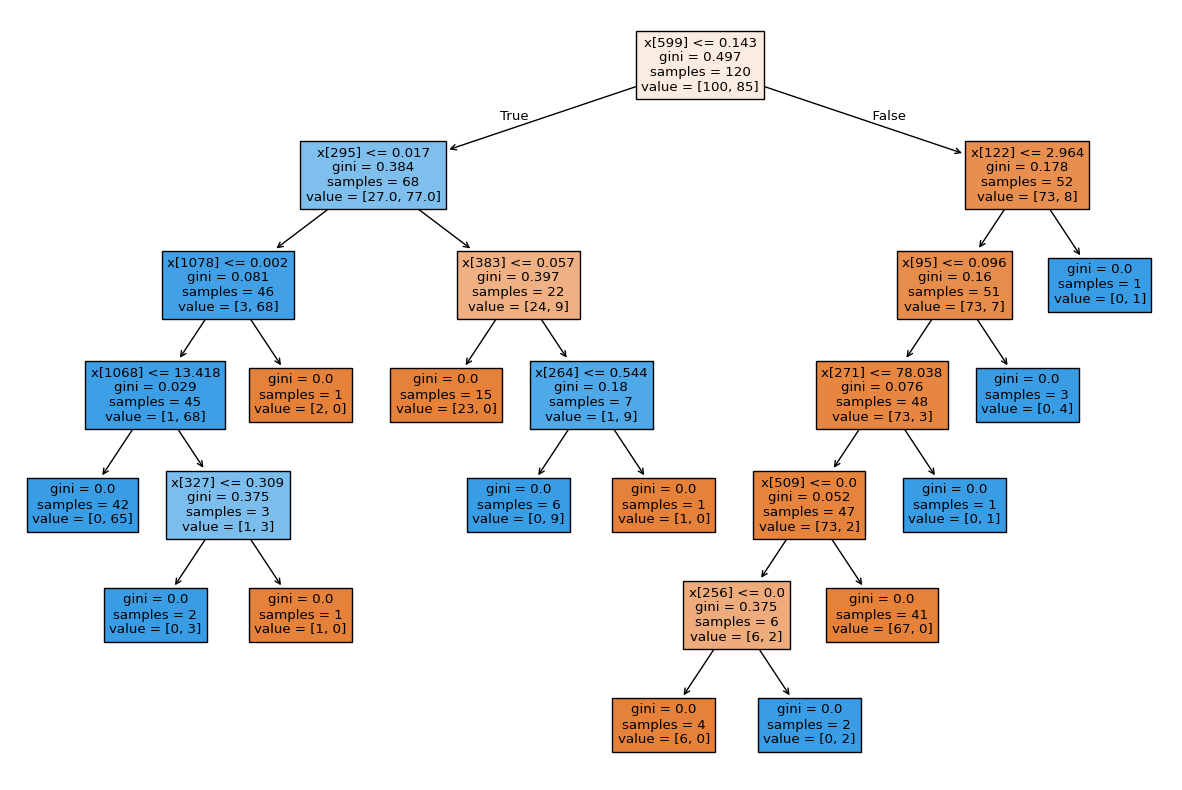

In [77]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(model.estimators_[2], filled=True)
plt.savefig('issues/RF_decision_tree_cirrhosis_ds.png', dpi=300)